In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

class Communicators(torch.nn.Module):
    def __init__(self, N):              # N is number of dimensions.
        super(Communicators, self).__init__()
        # creating 3 fully connected layers
        self.fc1 = torch.nn.Linear(2*N, 2*N)   # N bit values, N key values.# First fully connected layer
        self.fc2 = torch.nn.Linear(2*N, N) # Second fully connected layer
        self.fc3 = torch.nn.Linear(N, N) # output layer
        self.N = N
       
    
    def forward(self, x):
        
        # apply sigmoid activation function for all layers
        x = F.sigmoid(self.fc1(x)) # first layer
        x = F.sigmoid(self.fc2(x)) # second layer
        x = self.fc3(x) # output layer
        # apply tanh 
        x = F.tanh(x)
        
        return torch.squeeze(x)   # doubt 


In [10]:
# creating adversary network
class adversary(torch.nn.Module):
    def __init__(self, N):
        super(adversary, self).__init__()
        
        # creating 3 fully connected layers
        self.fc1 = torch.nn.Linear(N, 2*N)   # N bit values of ciphertext.# First fully connected layer
        self.fc2 = torch.nn.Linear(2*N, 2*N) # Second fully connected layer
        self.fc3 = torch.nn.Linear(2*N, N) # output layer
        self.N = N
        
    def forward(self, x):
        
        # apply sigmoid activation function
        x = F.sigmoid(self.fc1(x)) # first layer
        x = F.sigmoid(self.fc2(x)) # second layer
        # apply tanh
        x = self.fc3(x) # output layer
        x = F.tanh(x)
        return torch.squeeze(x)

In [11]:
def get_binary_data(batch,len):
    binary_input = (2*torch.randint(low = 0, high = 2, size = (batch, len)) - 1).float() 
    binary_input.requires_grad_(True)
    return binary_input

In [12]:
steps = []
bob_rc_error = []
eve_rc_error = []
ab_rc_error = []


def train3(batch_size, lr, iterations, size):
    #defining some hyperparameters.
    batch_size = batch_size     # 256 - 4096. # paper used 4096
    lr = lr                     # as per the paper.
    iterations = iterations     # paper used 25000
    size = size                 # size of the input data.



    alice = Communicators(size)
    bob = Communicators(size)
    eve = adversary(size)
    
    alice.train()
    bob.train()
    eve.train()


    #optimisers
    optimser_alice = Adam(params = alice.parameters(), lr = lr)
    optimser_bob = Adam(params = bob.parameters(), lr = lr)
    optimser_eve = Adam(params = eve.parameters(), lr = lr)

    for i in range(iterations):
        # train alice and bob 1 time.
        
        plain = get_binary_data(batch_size, size)
        key = get_binary_data(batch_size, size)

        alice_c = alice.forward(torch.cat((plain, key), dim = 1))
        # print(alice_c.shape)
        bob_p = bob.forward(torch.cat((alice_c, key), dim = 1))
        eve_p = eve.forward(alice_c)

        # loss functions page no. 6.
        error_bob = (nn.L1Loss()(bob_p, plain))/2.0 #average of fraction of wrongly predicted bits.
        error_eve = (nn.L1Loss()(eve_p, plain))/2.0 #average of fraction of wrongly predicted bits.
        ab_loss = error_bob + (1.0 - error_eve*2)**2

        optimser_alice.zero_grad()
        optimser_bob.zero_grad()
        ab_loss.backward()
        #clipping the gradients is not done.

        optimser_alice.step()
        optimser_bob.step()
        

        # train eve 2 times.
        for j in range(2):
            plain = get_binary_data(batch_size,size)
            key = get_binary_data(batch_size,size)
            alice_c = alice.forward(torch.cat((plain, key), dim = 1))
            eve_p = eve.forward(alice_c)

            error_eve = (nn.L1Loss()(eve_p, plain))/2.0
            optimser_eve.zero_grad()
            error_eve.backward()
            #clipping the gradients is not done.
            optimser_eve.step()
        
        steps.append(i)
        plain = get_binary_data(batch_size,size)
        key = get_binary_data(batch_size,size)
        alice_c = alice.forward(torch.cat((plain, key), dim = 1))
        bob_p = bob.forward(torch.cat((alice_c, key), dim = 1))
        eve_p = eve.forward(alice_c)

        error_bob = (nn.L1Loss()(bob_p, plain))/2.0
        error_eve = (nn.L1Loss()(eve_p, plain))/2.0
        ab_loss = error_bob + (1.0 - error_eve*2)**2
        
        bob_rc_error.append(error_bob.item())
        eve_rc_error.append(error_eve.item())
        ab_rc_error.append(ab_loss.item())

        if i%1000 == 0:
            print("Iteration: ", i, "  Bob Loss: ", error_bob.item())
            print("Iteration: ", i, "  Eve Loss: ", error_eve.item())
            print("Iteration: ", i, "  AB Loss: ", ab_loss.item())



    # in each iteration we will train alice,bob once and eve 2 times.

In [13]:
train3(batch_size = 256, lr = 0.0008, iterations = 25000, size = 16)

Iteration:  0   Bob Loss:  0.4999423921108246
Iteration:  0   Eve Loss:  0.5024019479751587
Iteration:  0   AB Loss:  0.49996545910835266
Iteration:  1000   Bob Loss:  0.407880038022995
Iteration:  1000   Eve Loss:  0.4091159403324127
Iteration:  1000   AB Loss:  0.4409196972846985
Iteration:  2000   Bob Loss:  0.4073888957500458
Iteration:  2000   Eve Loss:  0.474853515625
Iteration:  2000   AB Loss:  0.40991827845573425
Iteration:  3000   Bob Loss:  0.39527377486228943
Iteration:  3000   Eve Loss:  0.473317950963974
Iteration:  3000   AB Loss:  0.39812150597572327
Iteration:  4000   Bob Loss:  0.40314263105392456
Iteration:  4000   Eve Loss:  0.4770444631576538
Iteration:  4000   AB Loss:  0.4052504599094391
Iteration:  5000   Bob Loss:  0.38937920331954956
Iteration:  5000   Eve Loss:  0.4812155067920685
Iteration:  5000   AB Loss:  0.3907906413078308
Iteration:  6000   Bob Loss:  0.38864827156066895
Iteration:  6000   Eve Loss:  0.4773044288158417
Iteration:  6000   AB Loss:  0.390

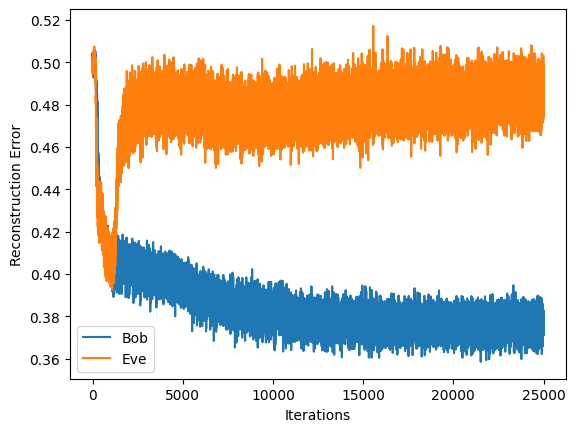

In [14]:
import matplotlib.pyplot as plt

plt.plot(steps, bob_rc_error, label = "Bob")
plt.plot(steps, eve_rc_error, label = "Eve")
plt.xlabel("Iterations")
plt.ylabel("Reconstruction Error")
plt.legend()

plt.show()

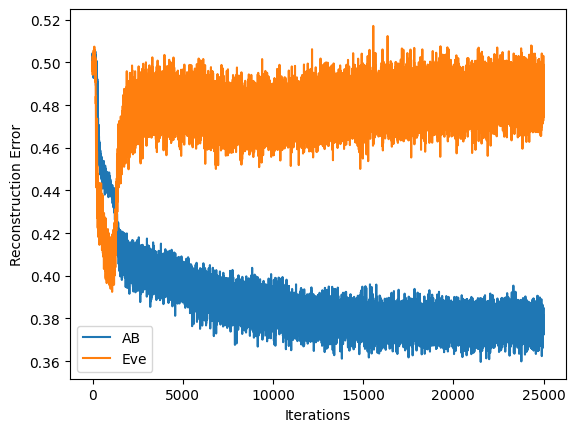

In [15]:

plt.plot(steps, ab_rc_error, label = "AB")
plt.plot(steps, eve_rc_error, label = "Eve")
plt.xlabel("Iterations")
plt.ylabel("Reconstruction Error")
plt.legend()

plt.show()